<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
import scikitplot as skplt

from matplotlib.colors import ListedColormap


In [3]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns', None)

In [4]:
# Load clean data
house = pd.read_csv('./house.csv')
house.head()

,id,property_subclass,property_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighbourhood,condition_1,condition_2,property_type,house_style,overall_quality,overall_condition,year_built,year_remodernisation_added,roof_style,roof_matl,exterior_material_1,exterior_material_2,masonry_veneer_type,masonry_veneer_area,external_material_quality,external_material_condition,foundation,basement_height_quality,basement_condition,basement_exposure,basement_finished_area_quality_type1,basement_type1_sqf,basement_finished_area_quality_type2,basement_type2_sqf,basement_unfinished_sqf,total_basement_area_sqft,heating,heating_quality,air_conditioning,electrical,First_floor_sqft,Second_floor_sqft,low_quality_finish_total_area_sqft,ground_living_space_sqft,basement_full_bathrooms,basement_half_bath,full_bathroom_above_grade,half_bathroom_above_grade,bedrooms_above_grade,kitchen_above_grade,kitchen_quality,total_rooms_above_grade,home_funcionality,fireplaces,fireplace_quality,garage_type,garage_year_built,garage_interior_finish,garage_cars_capacity,garage_sqft_area,garage_quality,garage_condition,paved_driveway,wood_deck_area_sqft,open_porch_area_sqft,enclosed_porch_area_sqft,Three_seasons_porch_area_sqft,screen_porch_area_sqft,fence,month_sold,year_sold,sale_type,sale_condition,sale_price,has_pool,age,sale_price_log
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,NaN,2,2008,WD,Normal,208500,0,5,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,NaN,5,2007,WD,Normal,181500,0,31,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,NaN,9,2008,WD,Normal,223500,0,7,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,NaN,2,2006,WD,Abnorml,140000,0,91,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,NaN,12,2008,WD,Normal,250000,0,8,12.429216


In [5]:
house['sale_condition'].value_counts()

Normal     1129
Abnorml      94
Partial      93
Family       20
Alloca        7
AdjLand       3
Name: sale_condition, dtype: int64

In [6]:
house_dict={'Normal':0,'Partial':0,'Abnorml':1,'Family':0,'Alloca':0,'AdjLand':0}
house['sale_condition'] = house['sale_condition'].map(house_dict)

In [7]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346 entries, 0 to 1345
Data columns (total 80 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    1346 non-null   int64  
 1   property_subclass                     1346 non-null   int64  
 2   property_zoning                       1346 non-null   object 
 3   lot_frontage                          1346 non-null   float64
 4   lot_area                              1346 non-null   int64  
 5   street                                1346 non-null   object 
 6   alley                                 88 non-null     object 
 7   lot_shape                             1346 non-null   object 
 8   land_contour                          1346 non-null   object 
 9   utilities                             1346 non-null   object 
 10  lot_config                            1346 non-null   object 
 11  land_slope       

In [8]:
#baseline
majority_class_pobability = house['sale_condition'].value_counts().max()/house['sale_condition'].count()
majority_class_pobability

0.9301634472511144

In [9]:
#baseline
minority_class_pobability = house['sale_condition'].value_counts().min()/house['sale_condition'].count()
minority_class_pobability

0.06983655274888559

### Target & predictors preprocessing

In [10]:
X = house.drop(['id','sale_price_log'], axis=1)
y = X.pop('sale_condition')


In [11]:
X = pd.get_dummies(X, drop_first = True)
X.columns

Index(['property_subclass', 'lot_frontage', 'lot_area', 'overall_quality',
       'overall_condition', 'year_built', 'year_remodernisation_added',
       'masonry_veneer_area', 'basement_type1_sqf', 'basement_type2_sqf',
       ...
       'fence_MnPrv', 'fence_MnWw', 'sale_type_CWD', 'sale_type_Con',
       'sale_type_ConLD', 'sale_type_ConLI', 'sale_type_ConLw',
       'sale_type_New', 'sale_type_Oth', 'sale_type_WD'],
      dtype='object', length=232)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size= 0.2, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [13]:
y_test.dtype

dtype('int64')

In [14]:
#confusion matrix function
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

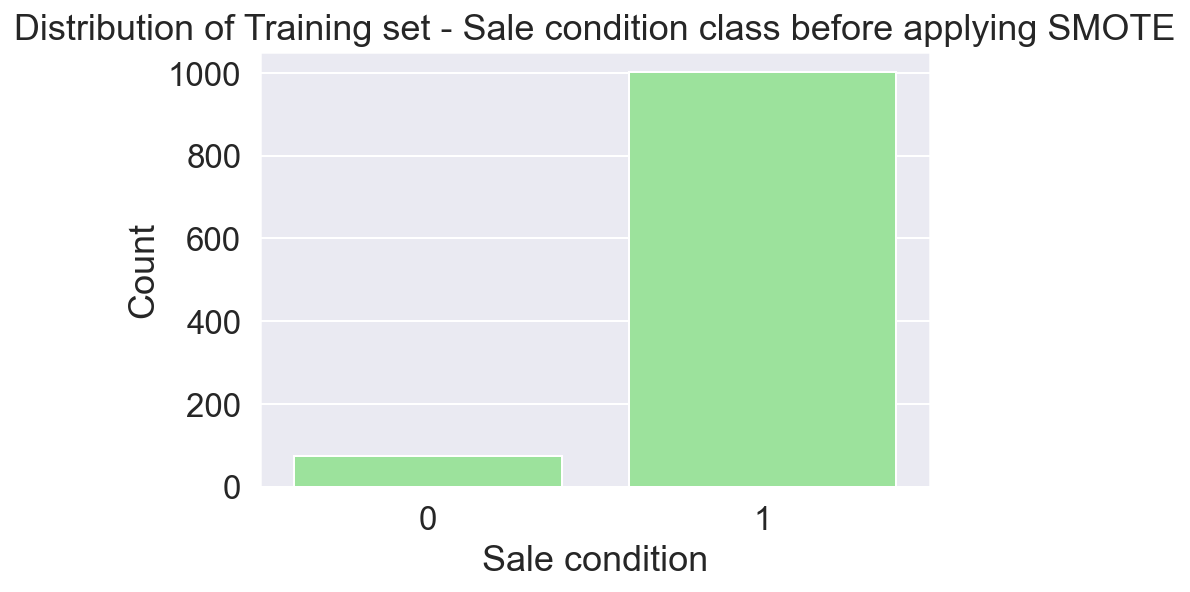

In [15]:
fig, ax = plt.subplots(ncols=1,figsize=(6,4))
sns.barplot(x=['0','1'], y=[y_train.value_counts()[1],y_train.value_counts()[0]], ax=ax,color='lightgreen')
ax.set(xlabel='Sale condition')
ax.set(ylabel='Count')
ax.set_title('Distribution of Training set - Sale condition class before applying SMOTE')
plt.show();

Severe class imbalance here. Let's run the modelling without addressing class imbalance first, then SMOTE will be applied.

### Modelling - before SMOTE

In [16]:
#models to be used
models = [KNeighborsClassifier(),
          LogisticRegression(max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100)]
#setting target and predictors

X = X
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
     random_state=1)

print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

res = []

for model in models:
    print('-'*60)
    print(model)
    print('-'*60)
    print()
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print('train score:', train_score)
    test_score = model.score(X_test, y_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X_train, y_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X_train, y_train, cv=5, n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y_pred = model.predict(X_test)
    print()
    cm = docm(y_test, y_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y_test, y_pred))
    print()
    res.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print('-'*60)
    print()

Models:
------------------------------------------------------------
KNeighborsClassifier()
------------------------------------------------------------

train score: 0.9321561338289963
test score: 0.9296296296296296
cross val score: [0.93055556 0.93023256 0.93023256 0.93023256 0.93023256]
cross val mean score: 0.930297157622739

Confusion matrix
   p_0  p_1
0  251    0
1   19    0

Classification report
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       251
           1       0.00      0.00      0.00        19

    accuracy                           0.93       270
   macro avg       0.46      0.50      0.48       270
weighted avg       0.86      0.93      0.90       270



------------------------------------------------------------
------------------------------------------------------------

------------------------------------------------------------
LogisticRegression(max_iter=1000)
---------------------------------------------

/Users/sandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train score: 0.9693308550185874
test score: 0.9185185185185185
cross val score: [0.86574074 0.89767442 0.89302326 0.89302326 0.90697674]
cross val mean score: 0.8912876830318691

Confusion matrix
   p_0  p_1
0  241   10
1   12    7

Classification report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       251
           1       0.41      0.37      0.39        19

    accuracy                           0.92       270
   macro avg       0.68      0.66      0.67       270
weighted avg       0.91      0.92      0.92       270



------------------------------------------------------------
------------------------------------------------------------

------------------------------------------------------------
DecisionTreeClassifier()
------------------------------------------------------------

train score: 1.0
test score: 0.8851851851851852
cross val score: [0.87962963 0.86976744 0.84186047 0.85116279 0.89767442]
cross val mean score: 0

/Users/sandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
summary = {'model': ['KNN','Logistic Regression', 'Decision Tree Classifier', 'Random Forest'],
          'training_score': [res[0][1], res[1][1], res[2][1], res[3][1]],
          'testing_score': [res[0][2], res[1][2], res[2][2], res[3][2]],
           'CV_mean_score': [res[0][4], res[1][4], res[2][4], res[3][4]]}

summary = pd.DataFrame.from_dict(summary)

summary.round(decimals=4)
                            

,model,training_score,testing_score,CV_mean_score
0,KNN,0.9322,0.9296,0.9303
1,Logistic Regression,0.9693,0.9185,0.8913
2,Decision Tree Classifier,1.0000,0.8852,0.8690
3,Random Forest,1.0000,0.9296,0.9303


### Modelling - applying SMOTE 

In [18]:
from collections import Counter

In [19]:
#models to be used
models2 = [KNeighborsClassifier(),
          LogisticRegression(max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100)]
#setting target and predictors

X2 = X
#train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.2,
     random_state=1)

#counting y before SMOTE
counter = Counter(y_train)
print('Class balance before SMOTE',counter)

#applying SMOTE to avoid class imbalance
oversample = SMOTE()
X2_train,y2_train = oversample.fit_resample(X2_train, y2_train)


#counting y after SMOTE
counter = Counter(y2_train)
print('Class balance after SMOTE',counter)
print()
print()
print('Baseline accuracy after oversampling:', y2_train.value_counts(normalize=True).max())
print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
X2_train = pd.DataFrame(scaler.fit_transform(X2_train), columns=X2.columns)
X2_test = pd.DataFrame(scaler.transform(X2_test), columns=X2.columns)

res2 = []

for model in models2:
    print(model)
    print()
    model.fit(X2_train, y2_train)
    train_score = model.score(X2_train, y2_train)
    print('train score:', train_score)
    test_score = model.score(X2_test, y2_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X2_train, y2_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X2_train, y2_train, cv=5,n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y2_pred = model.predict(X2_test)
    print()
    cm = docm(y2_test, y2_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y2_test, y2_pred))
    res2.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Class balance before SMOTE Counter({0: 1001, 1: 75})
Class balance after SMOTE Counter({0: 1001, 1: 1001})


Baseline accuracy after oversampling: 0.5
Models:
KNeighborsClassifier()

train score: 0.9530469530469531
test score: 0.8185185185185185
cross val score: [0.8478803  0.90274314 0.93       0.9175     0.9175    ]
cross val mean score: 0.9031246882793017

Confusion matrix
   p_0  p_1
0  217   34
1   15    4

Classification report
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       251
           1       0.11      0.21      0.14        19

    accuracy                           0.82       270
   macro avg       0.52      0.54      0.52       270
weighted avg       0.88      0.82      0.85       270


------------------------------------------------------------

LogisticRegression(max_iter=1000)

train score: 0.9825174825174825
test score: 0.9
cross val score: [0.81546135 0.97007481 0.975      0.97       0.975     ]
cross val mean 

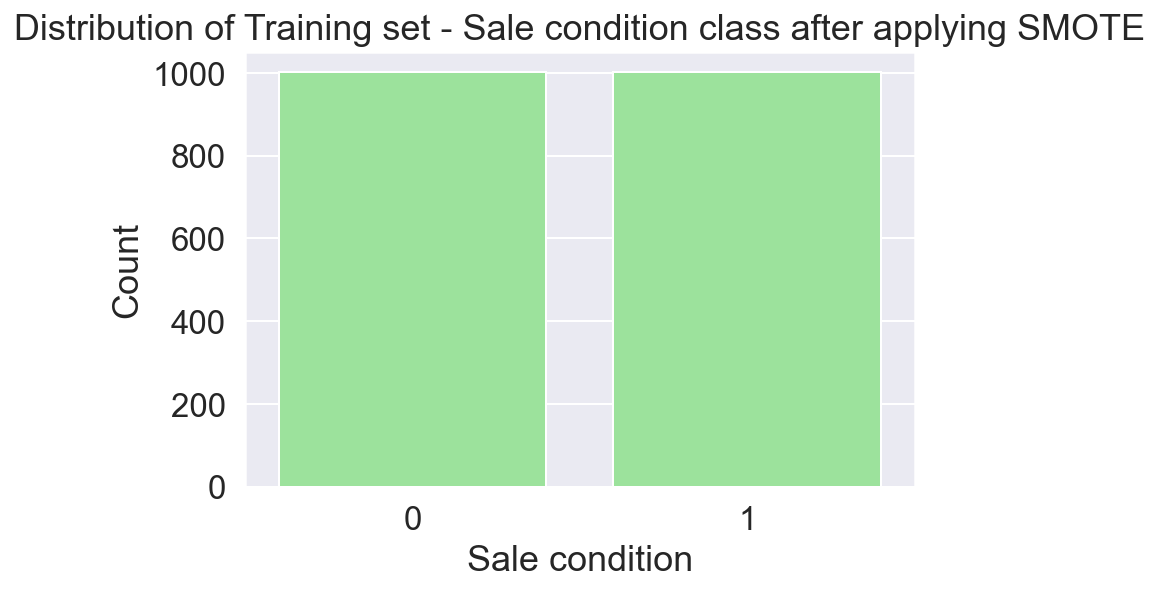

In [20]:
fig, ax = plt.subplots(ncols=1,figsize=(6,4))
sns.barplot(x=['0','1'], y=[y2_train.value_counts()[1],y2_train.value_counts()[0]], ax=ax,color='lightgreen')
ax.set(xlabel='Sale condition')
ax.set(ylabel='Count')
ax.set_title('Distribution of Training set - Sale condition class after applying SMOTE')
plt.show();

In [21]:
summary2 = {'model': ['KNN','Logistic Regression', 'Decision Tree Classifier', 'Random Forest'],
          'training_score': [res2[0][1], res2[1][1], res2[2][1], res2[3][1]],
          'testing_score': [res2[0][2], res2[1][2], res2[2][2], res2[3][2]],
           'CV_mean_score': [res2[0][4], res2[1][4], res2[2][4], res2[3][4]]}

summary2 = pd.DataFrame.from_dict(summary2)

print('Results with SMOTE oversampling')
summary2.round(decimals=4)
                            

Results with SMOTE oversampling


,model,training_score,testing_score,CV_mean_score
0,KNN,0.9530,0.8185,0.9031
1,Logistic Regression,0.9825,0.9000,0.9411
2,Decision Tree Classifier,1.0000,0.8259,0.9116
3,Random Forest,1.0000,0.9222,0.9731


In [22]:
print('Results without SMOTE oversampling')
summary.round(decimals=4)

Results without SMOTE oversampling


,model,training_score,testing_score,CV_mean_score
0,KNN,0.9322,0.9296,0.9303
1,Logistic Regression,0.9693,0.9185,0.8913
2,Decision Tree Classifier,1.0000,0.8852,0.8690
3,Random Forest,1.0000,0.9296,0.9303


With baseline of 0.93, results of modeling with significant class imbalance resulted in achieving fairly good scores. 
In case of modellling using smote, CV scores has improved with Logistic Regression. Let's gridsearch it, to see if further improvement can be achieved. 

In [23]:
model = LogisticRegression(verbose=1)
list(model.get_params().keys())

['C',
 'class_weight',
 'dual',
 'fit_intercept',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_jobs',
 'penalty',
 'random_state',
 'solver',
 'tol',
 'verbose',
 'warm_start']

In [24]:
model = LogisticRegression()
params = {'C': np.logspace(-4, 4, 10),
          'max_iter': [10000],
          'penalty': ['l2'],
          'fit_intercept': [True, False]}


gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True,
                 verbose=True)

gs.fit(X2_train, y2_train)

# extract the grid search results

print('Best Parameters:')
print(gs.best_params_)
print('Best estimator C:')
print(gs.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(X2_train, y2_train))
print('Best estimator score on the test set:')
print(gs.score(X2_test, y2_test))
print('Best estimator coefficients:')
print(gs.best_estimator_.coef_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:
{'C': 0.005994842503189409, 'fit_intercept': False, 'max_iter': 10000, 'penalty': 'l2'}
Best estimator C:
0.005994842503189409
Best estimator mean cross validated training score:
0.9605910224438905
Best estimator score on the full training set:
0.9685314685314685
Best estimator score on the test set:
0.9259259259259259
Best estimator coefficients:
[[ 4.42951792e-02  2.25335369e-02 -3.93437530e-02 -9.46975928e-02
  -1.34925067e-01 -2.97396545e-02 -1.20196879e-01  3.86835054e-02
   1.60899625e-02  3.81784974e-02 -1.92669745e-03  3.79972608e-02
   4.75527551e-02  1.28394132e-02  2.68364856e-02  4.70316028e-02
  -1.14636886e-01 -1.56235848e-02 -1.43680520e-01 -1.10447269e-01
  -9.77233337e-02 -1.62367951e-03 -5.42970865e-02 -6.21358018e-02
   2.44274133e-02 -4.75524161e-02 -9.21609899e-03  4.20271288e-02
  -8.69051121e-03  6.43529306e-02  2.37445849e-03  6.96991903e-02
   2.80961322e-02 -1.78532155e-01 -7.262602

In [25]:
best_model = LogisticRegression(C = 0.005994842503189409, fit_intercept = False, penalty = 'l2', max_iter=10000)
best_model.fit(X2_train, y2_train)
test_score = best_model.score(X2_test, y2_test)
train_score = best_model.score(X2_train, y2_train)
print('test score:', test_score)
print('train score', train_score)

test score: 0.9259259259259259
train score 0.9685314685314685


With baseline of 0.93, testing resulted with higher score than baseline. Let's look below at the confusion matrix and clasification report to check the metrics and evaluate the model 

In [26]:
best_model_features = pd.DataFrame({'feature': X2_train.columns,
                            'coef': best_model.coef_[0],
                            'abs_coef': np.abs(best_model.coef_[0]),
                            'odds': np.exp(best_model.coef_[0]),
                            'probability of odds': np.exp(best_model.coef_[0])/1+np.exp(best_model.coef_[0]),})
best_model_features.sort_values('coef', inplace=True, ascending=False)
best_model_features.head()

,feature,coef,abs_coef,odds,probability of odds
230,sale_type_Oth,0.081486,0.081486,1.084898,2.169796
31,screen_porch_area_sqft,0.069699,0.069699,1.072186,2.144371
29,enclosed_porch_area_sqft,0.064353,0.064353,1.066469,2.132937
125,exterior_material_1_Stone,0.062603,0.062603,1.064604,2.129208
69,neighbourhood_NoRidge,0.057124,0.057124,1.058787,2.117574


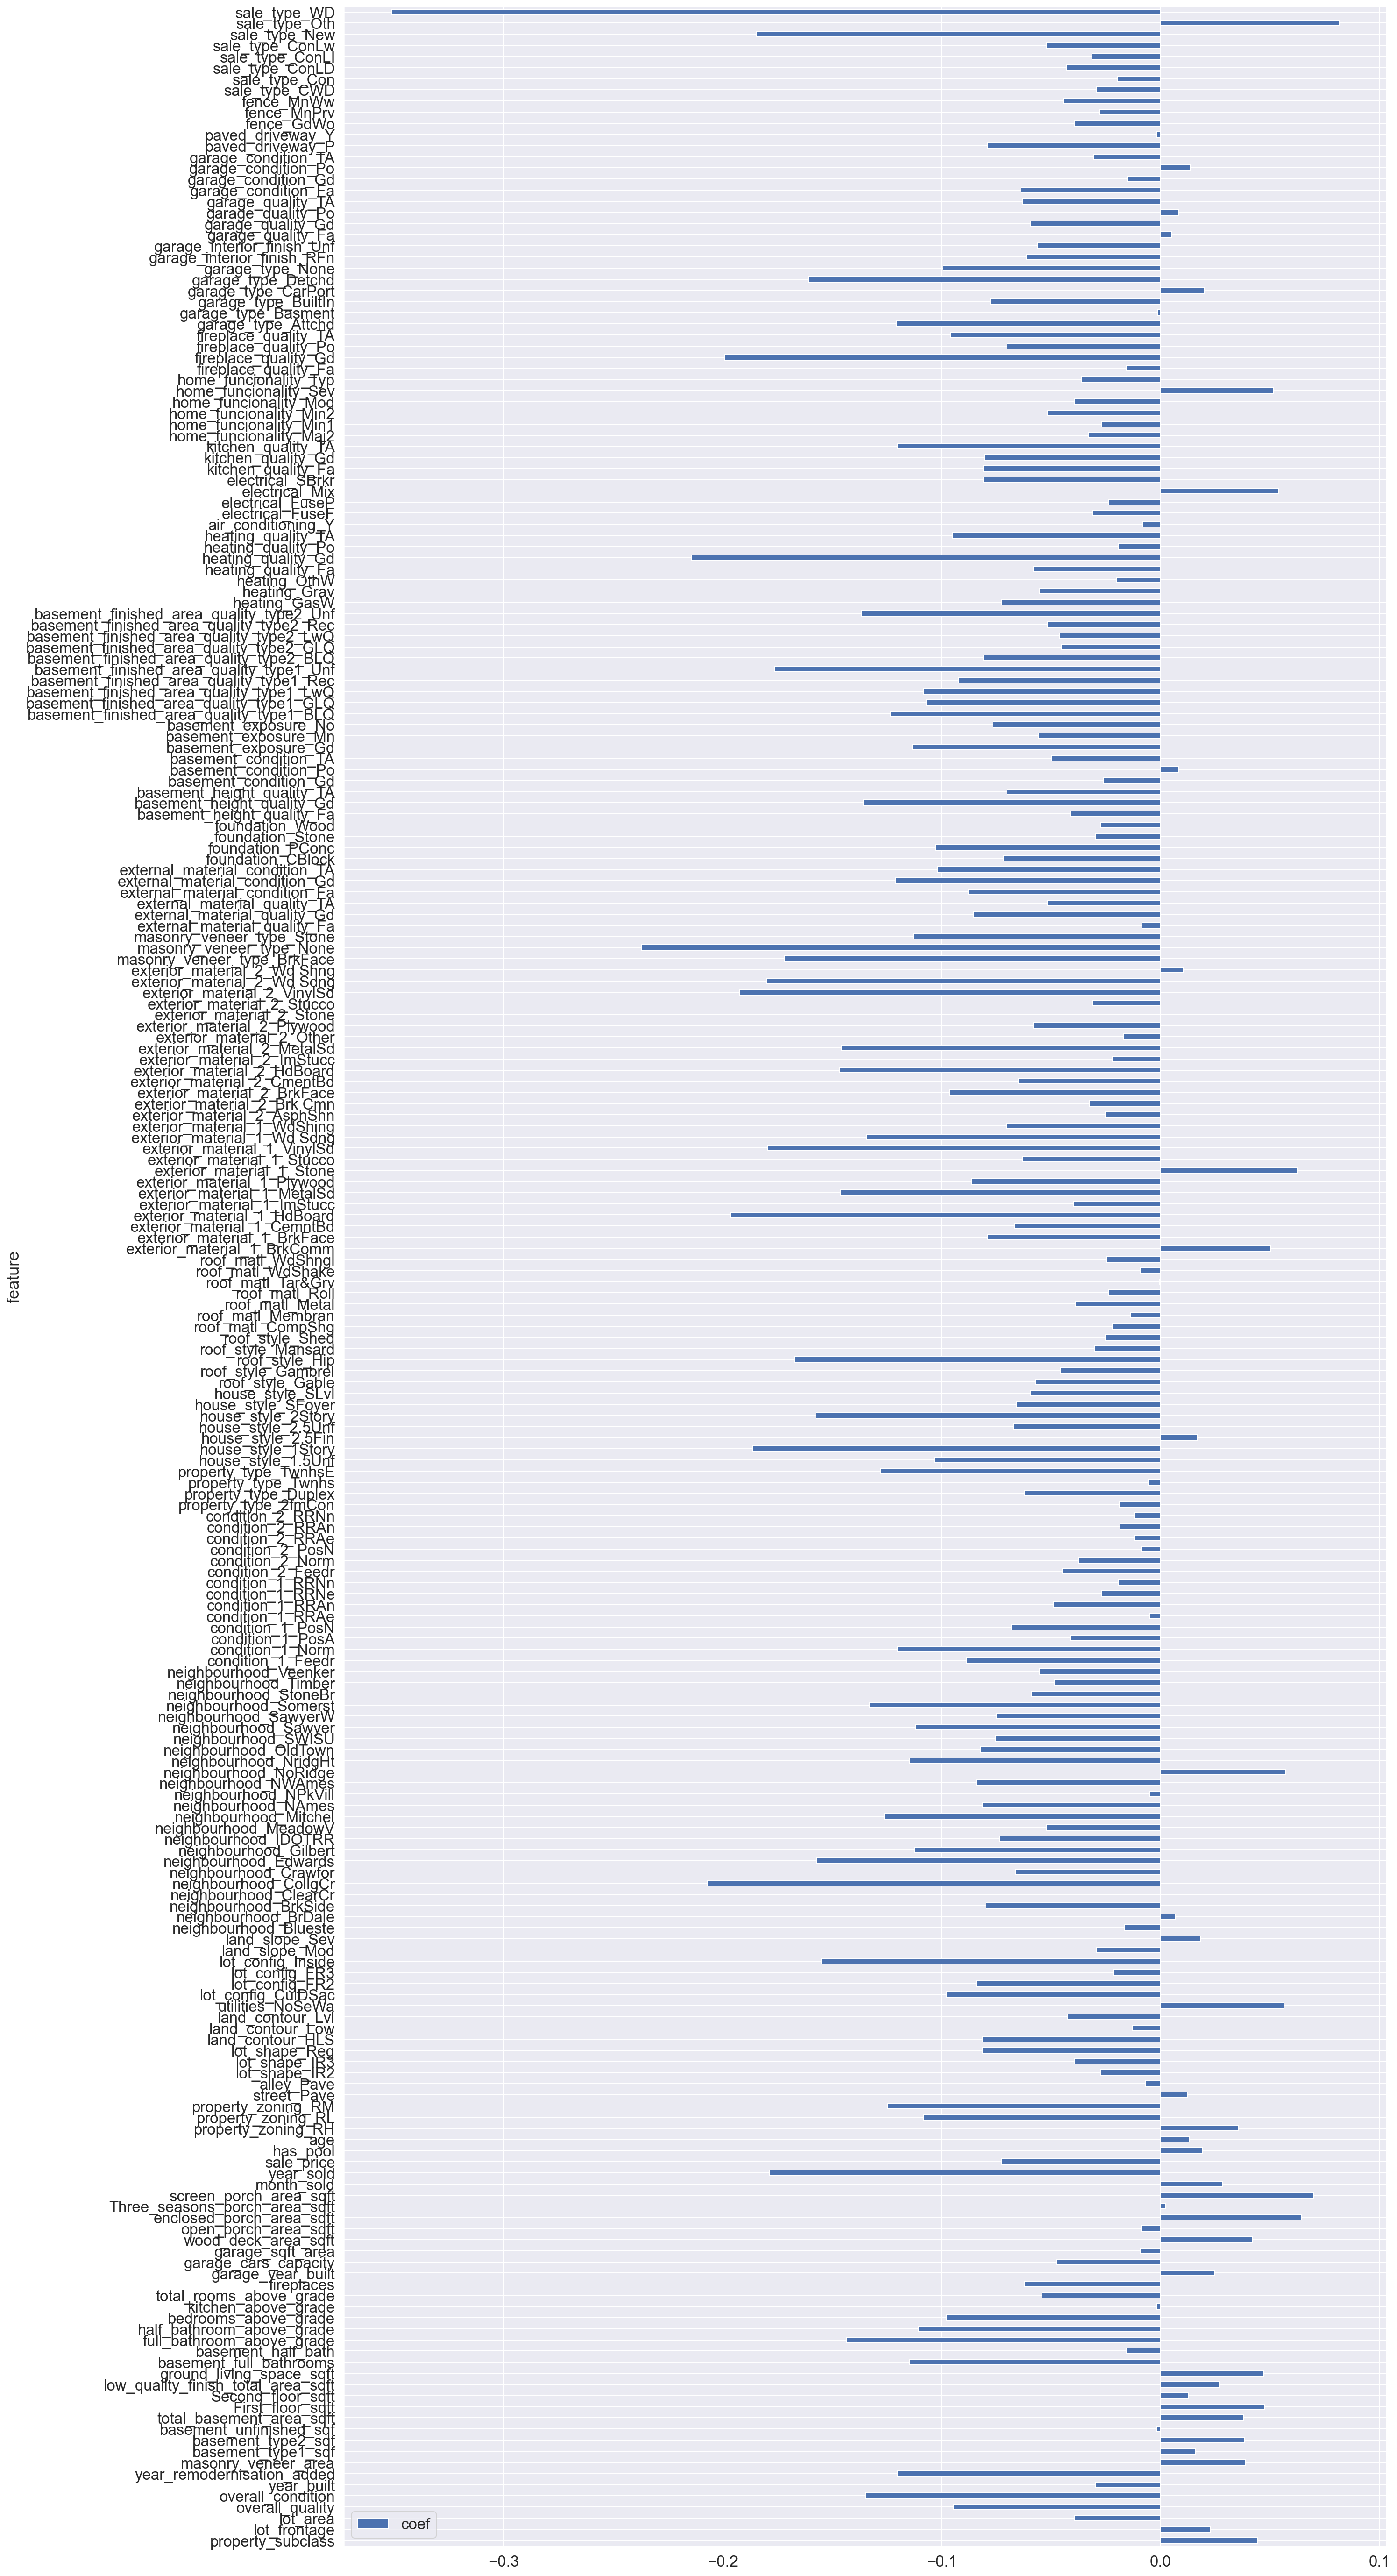

In [27]:
feature_plot = pd.DataFrame(list(zip(X2.columns, best_model.coef_[0])), 
                            columns=['feature', 'coef'])
feature_plot = feature_plot[feature_plot['coef'] !=0]
feature_plot.plot(kind='barh', x='feature', y='coef', figsize=(20, 50))
plt.show()

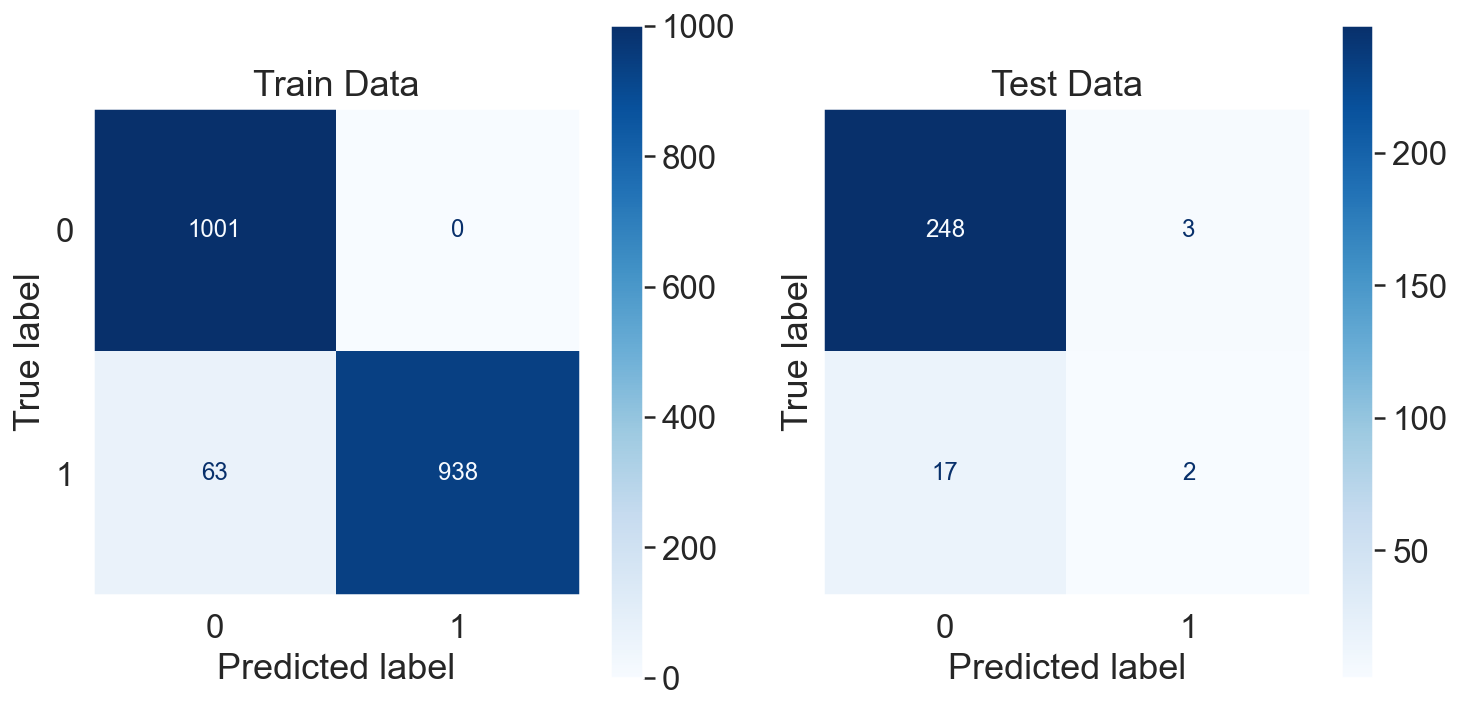

In [28]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
ax[0].grid(False)
ax[1].grid(False)
plot_confusion_matrix(best_model, X2_train, y2_train, cmap='Blues', ax=ax[0])
plot_confusion_matrix(best_model, X2_test, y2_test, cmap='Blues', ax=ax[1])
ax[0].set_title('Train Data')
ax[1].set_title('Test Data')

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(12)
plt.show()

The classification matrix resulted in:
    
Train data 
* 1000 true positive predictions ->classifier correct, normal sale condition predicted as normal
* 940 true negative predictions ->classifier correct, abnormal sale predicted as abnormal
* 1 false positive predictions->classifier incorrect, normal sale predicted as abnormal
* 61 false negative predictions>classifier incorrect, abnormal sale predicted as normal

Test data 

* 249 true positive predictions ->classifier correct, normal sale condition predicted as normal
* 2 true negative predictions ->classifier correct, abnormal sale predicted as abnormal
* 2 false positive predictions->classifier incorrect, normal sale predicted as abnormal
* 17 false negative predictions>classifier incorrect, abnormal sale predicted as normal


The matrix is very useful in checking performance of the model. It helps us gain an insight into how correct our predictions were and how they hold up against the actual values.


In [29]:
predictions = best_model.predict(X2_test)
print(classification_report(y2_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       251
           1       0.40      0.11      0.17        19

    accuracy                           0.93       270
   macro avg       0.67      0.55      0.56       270
weighted avg       0.90      0.93      0.91       270



Precision is the ratio between the True Positives and all the Positives. In problem presented here,  it is the measure of sale condition that are correctly identified as abnormal out of all sale condition classified as abnormal. In other words, precision shows what proportion of positive class were actually positive. In modele presented here its 94 % in class 0 and 0.50 % in class 1 .

The recall is the measure of the model correctly identifying True Positives. For all the sale condition which actually were abnormal, recall tells us how many we correctly identified as being abnormal. Recall in here is 0.99 for normal sale and 0.11 for abnormal sale class, meaning 75 % and 60 % of samples were correctly identified.


Accuracy is the ratio of the total number of correct predictions and the total number of predictions. In this model its 93%, therefore the missclassification rate is 0.07 - 7%, which explains some of the unexpected results. 

In this dataset, I would consider achieving a high recall more important than getting a high precision – The aim is to detect as many abnormal sales as possible.

F1 score is a harmonic man of precision and recall, that sometimes is taken into concideration instead of trying to find balance between precision and recall. Higher F1 score, better precision and recall.

In [30]:
probabilities_train = best_model.predict_proba(X2_train)
probabilities_test = best_model.predict_proba(X2_test)

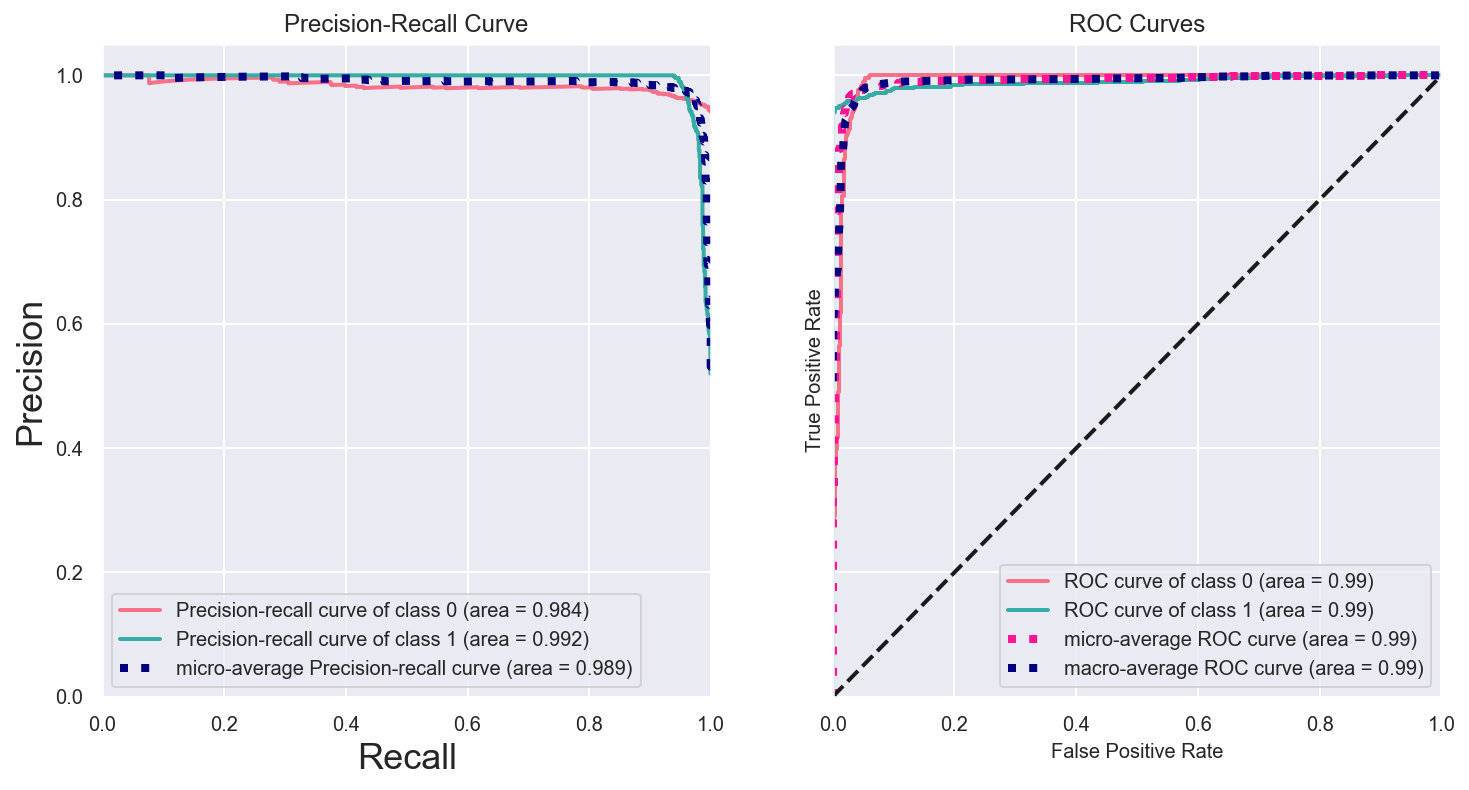

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
cmap = ListedColormap(sns.color_palette("husl", len(best_model.classes_)))
skplt.metrics.plot_precision_recall(y2_train, probabilities_train, cmap=cmap, ax=ax[0])
skplt.metrics.plot_roc(y2_train, probabilities_train, cmap=cmap, ax = ax[1])
plt.show()

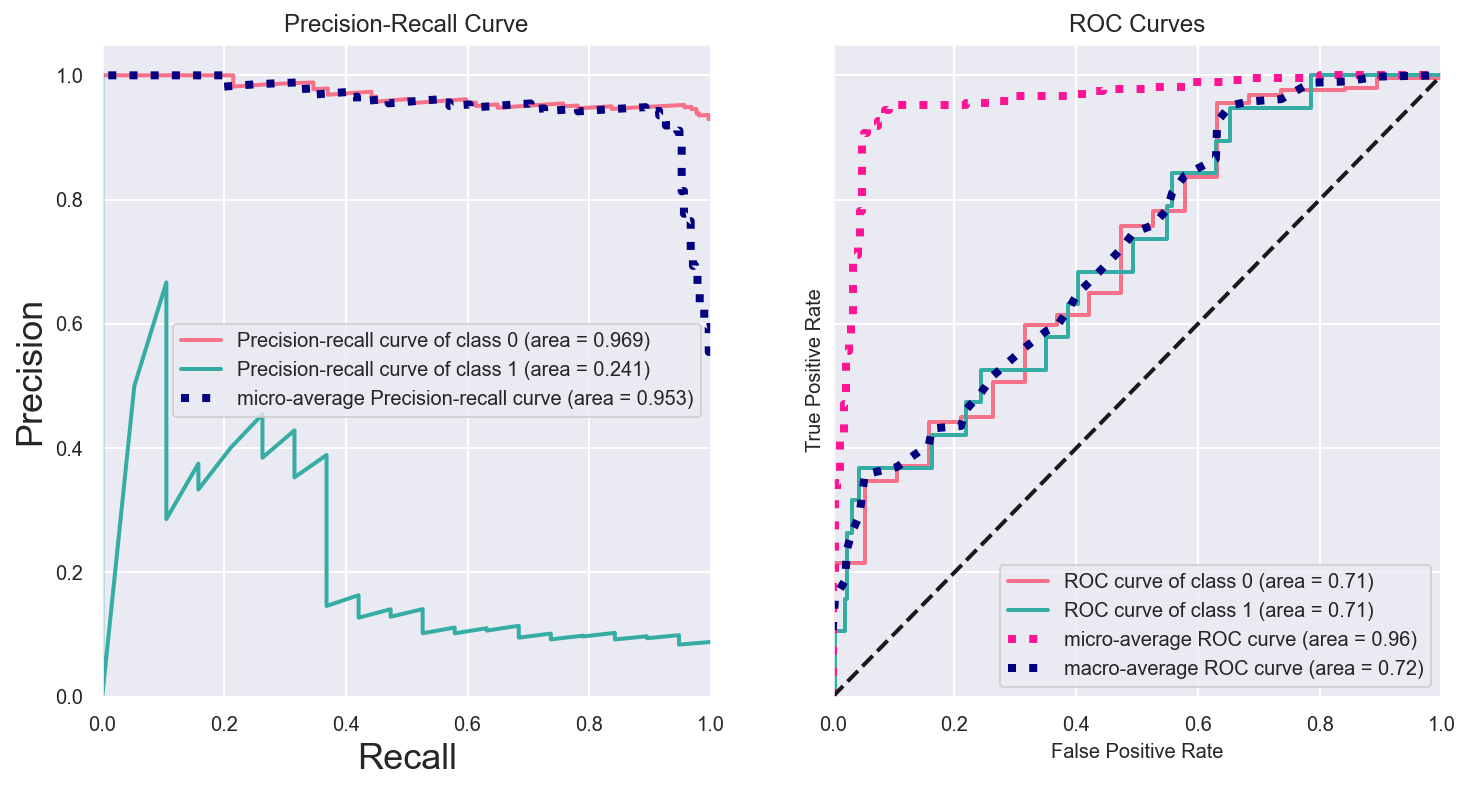

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
cmap = ListedColormap(sns.color_palette("husl", len(best_model.classes_)))
skplt.metrics.plot_precision_recall(y2_test, probabilities_test, cmap=cmap, ax=ax[0])
skplt.metrics.plot_roc(y2_test, probabilities_test, cmap=cmap, ax = ax[1])
plt.show()

This Precission recall curve shows the trade off between precission and recall for different threshold. It measures how successfull prediction is when classes are very imbalanced. A high area under the curve represents both high recall and high precission, where high precission indicate a low false positive rate and a high recall indicate low false negative rate. The graph shows very high AUC scores, confirming the model can be trusted in sale condition based on the majority of the predictors chosen for the model. However thats the case for the training set. If we look at the testing set the score for normal sale condition is still very good, 0.968, however it is expremely poor for class 1 - abnormal sale condition, achieving only 0.234.

The receiver operating characteristic curve is another evaluation tool to see the performance of binary classification algorithms. It provides a graphical overal representation of classifier as a whole rather than a single value. 
Similary like with the graph above, the higher area under the curve, higher AUC score the better classifier performs. 

ROC AUC takes into account TPR and FPR:
Recall/TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
so it multiplies TPR and FPR at each threshold. The score displayed on the graph its the sum of scores at each threshold. 

A perfect classifier will have a ROC AUC equal to 1. If the TPR is 1, the area under the curve is 1 (it cannot be larger), this is equivalent to perfect prediction.
Higher the ROC AUC, the better prediction aka the performance of the model at distinguishing between the positive and negative classes. In model presented, ROC AUC of 0.99 (train set) means the model correctly predicted 99% of the observations. Thats not the case in test set, where ROC AUC achieved 0.70 for both classes meaning 70% of the observation are corectly classified. 

Let's see if we can improve model preformance by adjusting the threshold

In [33]:
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0
print(probabilities_test.mean())

0.5


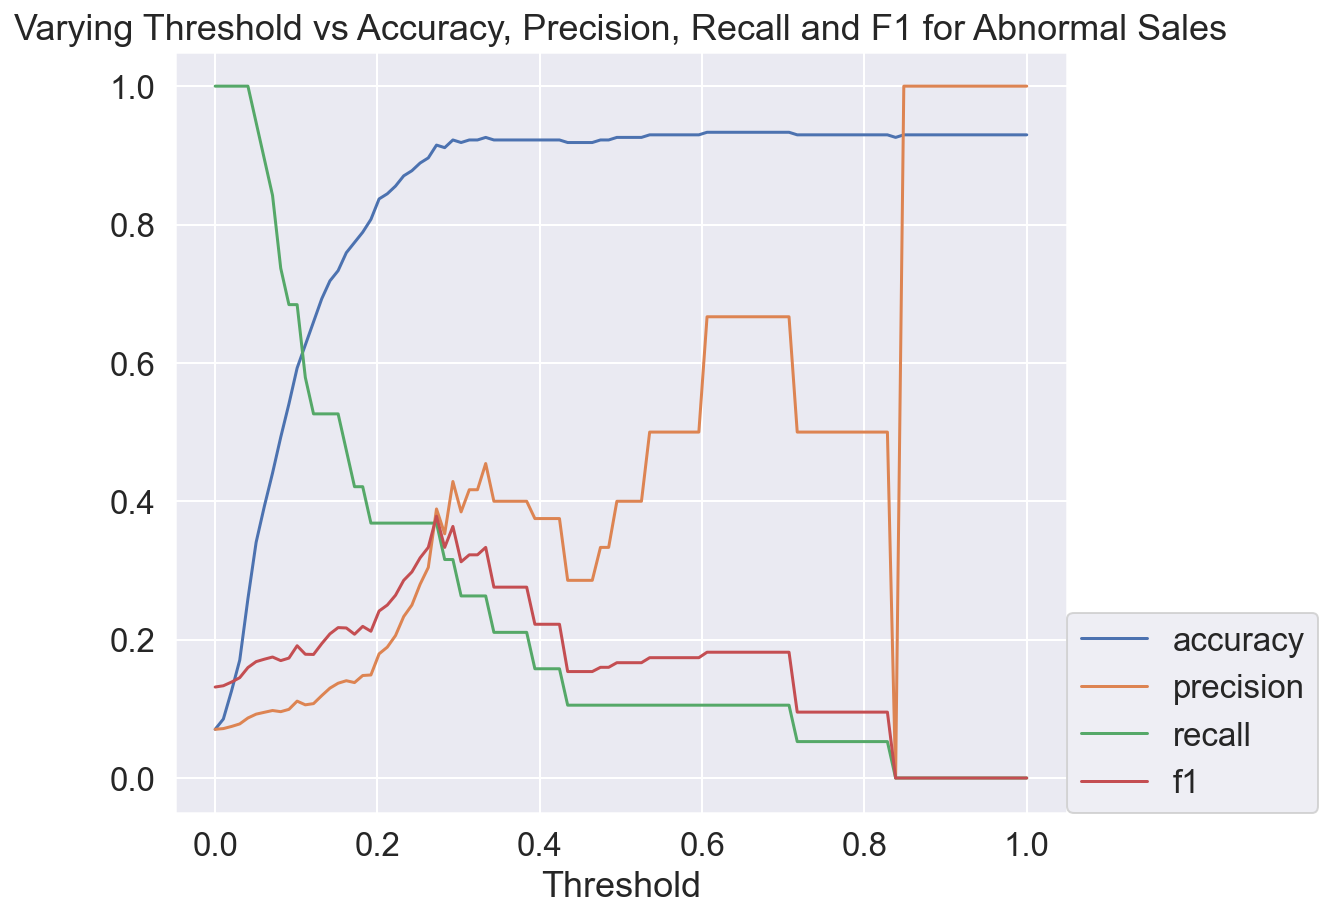

In [34]:
from sklearn.metrics import f1_score

def scores_at_thresholds(probs, test_data):
    predictions = [probs.apply(predict_at_threshold, threshold=i) 
                   for i in np.linspace(0, 1, 100)]
    scores = np.array(
    [(threshold, 
      accuracy_score(test_data, predictions[i]),
      precision_score(test_data, predictions[i], zero_division = 1),
      recall_score(test_data, predictions[i]), 
      f1_score(test_data, predictions[i])) 
     for i, threshold in enumerate(np.linspace(0, 1, 100))])
    return scores

Y_pp = pd.DataFrame(best_model.predict_proba(X2_test), 
             columns=['class_0_pp', 'class_1_pp'])

scores = scores_at_thresholds(Y_pp.class_1_pp, y2_test)

plt.figure(figsize=(8,7))
plt.plot(scores[:, 0], scores[:, 1], label='accuracy')
plt.plot(scores[:, 0], scores[:, 2], label='precision')
plt.plot(scores[:, 0], scores[:, 3], label='recall')
plt.plot(scores[:, 0], scores[:, 4], label='f1')
plt.legend(loc=[1, 0])
plt.xlabel('Threshold')
plt.title('Varying Threshold vs Accuracy, Precision, Recall and F1 for Abnormal Sales')
plt.show()

In [35]:
Y_pp['pred_class_thresh'] = Y_pp.class_1_pp.apply(predict_at_threshold, threshold=0.60)    

print(classification_report(y2_test, Y_pp.pred_class_thresh))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       251
           1       0.50      0.11      0.17        19

    accuracy                           0.93       270
   macro avg       0.72      0.55      0.57       270
weighted avg       0.91      0.93      0.91       270



In [36]:
Y_pp['pred_class_thresh'] = Y_pp.class_1_pp.apply(predict_at_threshold, threshold=0.15)    

print(classification_report(y2_test, Y_pp.pred_class_thresh))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84       251
           1       0.14      0.53      0.22        19

    accuracy                           0.73       270
   macro avg       0.55      0.64      0.53       270
weighted avg       0.90      0.73      0.80       270



In [37]:
Y_pp['pred_class_thresh'] = Y_pp.class_1_pp.apply(predict_at_threshold, threshold=0.28)    

print(classification_report(y2_test, Y_pp.pred_class_thresh))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       251
           1       0.35      0.32      0.33        19

    accuracy                           0.91       270
   macro avg       0.65      0.64      0.64       270
weighted avg       0.91      0.91      0.91       270



Looking at precision, recall and F1-scores and accuracy versus varying threshold plot, we can try to identify the optimum level at which we are able to make better prediction of the abnormal sale condition.
Since we are dealing with high class imbalance, we need to compromise on the metrics a bit, in a sense that adjusting the threshold to a point were we are able to capture all of the class one samples (abnormal sale condition), but it may come at expence of reduced model accuracy. 